In [4]:

import jax
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
from ima.ima.mixing_functions import build_moebius_transform
import GPy

In [5]:

plt.ion(); plt.style.use('seaborn-pastel')
np.random.seed(42)

In [6]:


n, d, D = 500, 2, 2

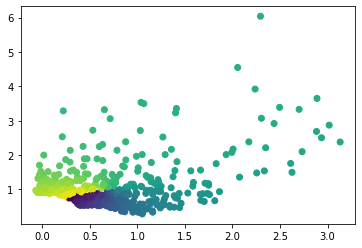

In [7]:

Z = np.random.uniform(-0.5, 0.5, size=(n, d))
c = np.arctan2(Z[:, 1], Z[:, 0])

# plt.scatter(Z[:, 0], Z[:, 1], c=c)

A = ortho_group.rvs(dim=D)
A = jax.numpy.array(A)

alpha = 1.0
a = []
while len(a) < D:
    s = np.random.randn()
    if np.abs(s) > 0.5:
        a = a + [s]
a = jax.numpy.array(a)
b = jax.numpy.zeros(D)

mixing, _ = build_moebius_transform(alpha, A, a, b, epsilon=2)

X = jax.vmap(mixing)(Z)
plt.scatter(X[:, 0], X[:, 1], c=c)

Optimization restart 1/3, f = 831.0181343696695
Optimization restart 2/3, f = 927.0682170074494
Optimization restart 3/3, f = 927.0690553171407


100%|██████████| 30/30 [00:01<00:00, 20.48it/s]


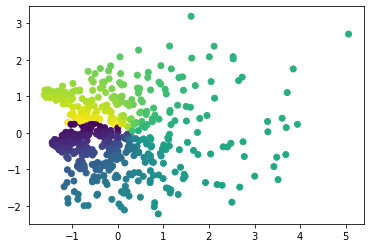

In [8]:


kernel = GPy.kern.RBF(2, ARD=False) + GPy.kern.Bias(2)
m = GPy.models.BayesianGPLVM(np.asarray(X), 2, kernel=kernel, num_inducing=20)
m.optimize_restarts(3, optimizer='lbfgs')

def C_ima_sample():
    z = np.random.normal(m.X.mean, m.X.variance**0.5)
    dmu_dX, dv_dX = m.predict_jacobian(z) # this seems to be latents * data dim
    dv_dX[dv_dX <= 0] = 1e-6
    jacobian_sample = np.random.normal(dmu_dX, dv_dX**0.5)
    jacobian_sample = np.einsum('aik,ajk->aij', jacobian_sample, jacobian_sample).mean(axis=0)
    return np.log(np.linalg.det(np.diag(np.diag(jacobian_sample)))) -\
           np.log(np.linalg.det(jacobian_sample))

def C_ima():
    from tqdm import trange
    return np.mean([C_ima_sample() for _ in trange(30)])
C_ima()

Zest = m.X.mean
plt.scatter(Zest[:, 0], Zest[:, 1], c=c)